## Implementing Strategy B 

### Differences between Strategy A and Strategy B
"Strategy A" and "Strategy B" have, in common, five scalar parameters required by QLC-2. These are:
- $L$ (crystal dimension)
- $\tau_{eq}$, $\sigma_o$, $\overline N$, and $N^*$ (all atomistic-level characteristics of the ice surface)

In Strategy A, four additional parameters are supplied to QLC-2: 
- $D_{surf}$ (surface diffusion coefficient of the QLL)
- $\nu_{kin}$ (rate at which water vapor strikes the surface)
- $\sigma_{I,corner}$ and $\sigma_{I,middle}$ (water vapor supersaturation above the corner and middle of the crystal)

By contrast, Strategy B's additional parameters are
- $T$ (ambient temperature)
- $P$ (ambient air pressure)
- $\sigma_{I,far}$ and $x_{far}$ (super/subsaturation of water vapor far from the crystal, and distance from the crystal at which $\sigma_{I,far}$ is specified)

These four parameters are then used to compute the four Strategy A parameters. Specifically, $D_{surf}$ and $\nu_{kin}$ are obtained from the ambient temperature using an Arrhenius formula and the Hertz-Knudsen formula;  $\sigma_{I,corner}$ and $\sigma_{I,middle}$ are obtained from vapor field calculations. The latter are based on the ambient temperature and pressure, the size of the crystal, and far-field vapor parameters $\sigma_{I,far}$ and $x_{far}$. Strategy B is therefore a more integrated and experimentally accessible strategy for parameterizing QLC-2 simulations.

### Recap of the equivalent circumference assumption and the circular approximation
Here we recap the results developed in VF_testing2D.ipynb to predict $P_{vap}$ surrounding a square crystal. We first note that the square crystal we are trying to represent has a side length, $L$, and therefore a perimeter ($8L$). We then specify the radius of an "equivalent circular crystal," $L_{equiv}$, such that the circumference of the circular crystal equals the perimeter of the square crystal. This equivalent circle has the property $L < L_{equiv} < L_{corner}$; for example, when $L=50 \ \mu m$, $L_{equiv}=64 \ \mu m$ and $L_{corner}=71 \ \mu m$.

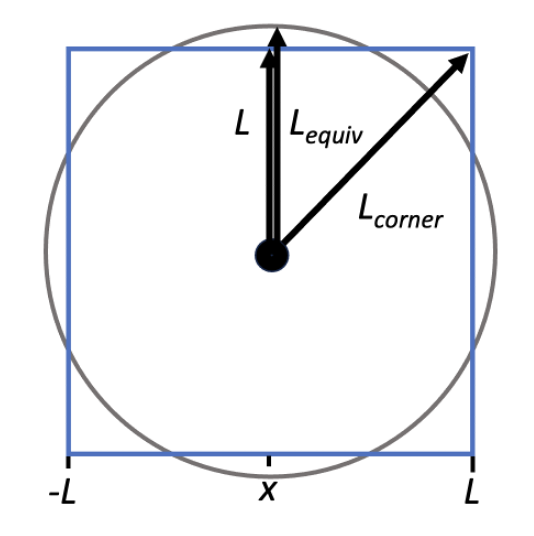

Next, we note that the concentration of vapor around our equivalennt circular crystal has the analytical solution

$$
P_{vap} = P_1 \times (1-{r_0 \over r}) \ \ \ \ (1)
$$

where $P_1$ and $r_0$ depend on $L_{equiv}$, $\sigma_{I,far}$, $x_{far}$, the equilbrium vapor pressure of water at a given temperature, $P_{vap}^{eq}$, and the diffusivity of vapor through air, $D_{vap}$. The latter is computed by

$$
D_{vap} = D_{vap}^o \times { { ({T \over T^o})^m} \over {{P \over P^o}} } \ \ \ \ (2)
$$

(See VF_testing2D.ipynb for details.) Evaluating Eq. 1 at crystal corners leads to

$$
P_{L,corner} \equiv P_{vap}(L_{corner}) = P_1 \times (1-{r_0 \over L_{corner}}) \ \ \ \ (3)
$$

while evaluation at the middle of facets leads to 

$$
P_{L,middle} \equiv P_{vap}(L) = P_1 \times (1-{r_0 \over L}) \ \ \ \ (4)
$$

Then we can define a "center reduction,"

$$
c_r \equiv {P_{L,corner} - P_{L,middle} \over P_{L,corner}} \ \ \ \ (5)
$$

A caveat: Eq. 1 assumes that a growing square-shaped crystal influences the overlying vapor field in the same way that a growing circular crystal does. This isn't quite correct: as the numerical solutions in VF_testing2D.ipynb show, for a test case, the equivalent circular approximation produced about double the center reduction obtained by the (more exact) numerical analysis. The reason is, vapor contours close to a square-shaped crystal tend to conform to the flat surfaces of the crystal. That flattening-out reduces differences in vapor concentration between corners and middles of a given side of a square.

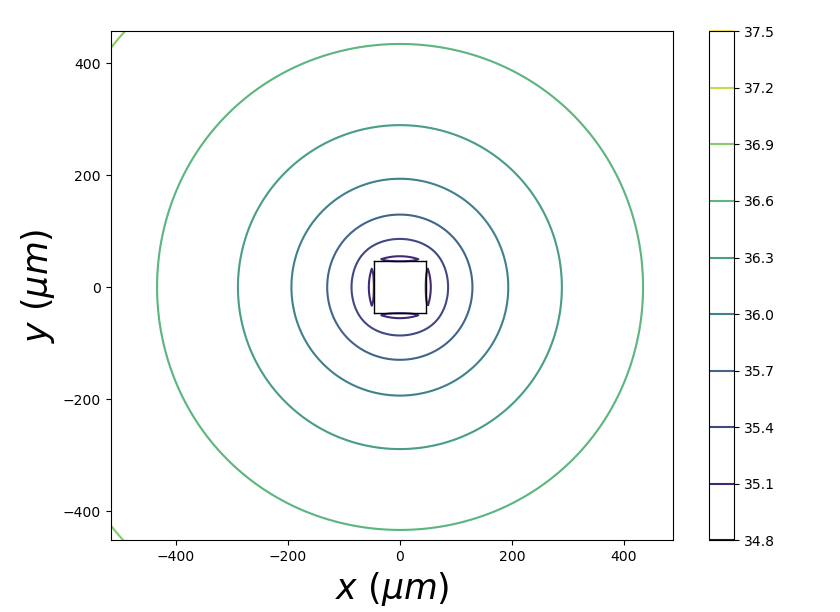

### Iterative solution for determining $g_{ice}$ in Strategy B
For a given set of parameters, Eq. 1 uses an assumed value of the growth rate, $g_{ice}$ to predict a surface vapor concentration profile, $\sigma_I(x)$. The QLC-2 algorithm, meanwhile, takes $\sigma_I(x)$ as input, and produces a value for $g_{ice}$. To obtain a self-consistent growth rate, therefore, requires an iterative approach. Here, we do so in two stages:

1. Use Eq. 1 to map $g_{ice} → \sigma_I(x)$, then use the 0D implementation of QLC-2 to map $\sigma_I(x) → g_{ice}$ (repeat until $g_{ice}$ converged)
1. Use Eq. 1 to map $g_{ice} → \sigma_I(x)$, then use the 1D implementation of QLC-2 to map $\sigma_I(x) → g_{ice}$ (repeat until $g_{ice}$ converged)

The reason for these two stages is that the 0D implementation of QLC-2 does most of the iterative work, and is much faster than the 1D implementation.

### The parabolic approximation for surface vapor concentrations
It turns out that a parabolic approximation to the vapor concentration at the surface of the ice is convenient and sufficiently accurate for our purposes. The parabolic approximation is

$$
P_{surf}(x) \approx P_{L,middle} +P_{L,corner} \times c_r \times ({x \over L})^2 \ \ \ \ (6)
$$

where $x=0$ coincides with the middle of a facet, and $x=L$ coincides with the facet corner. 

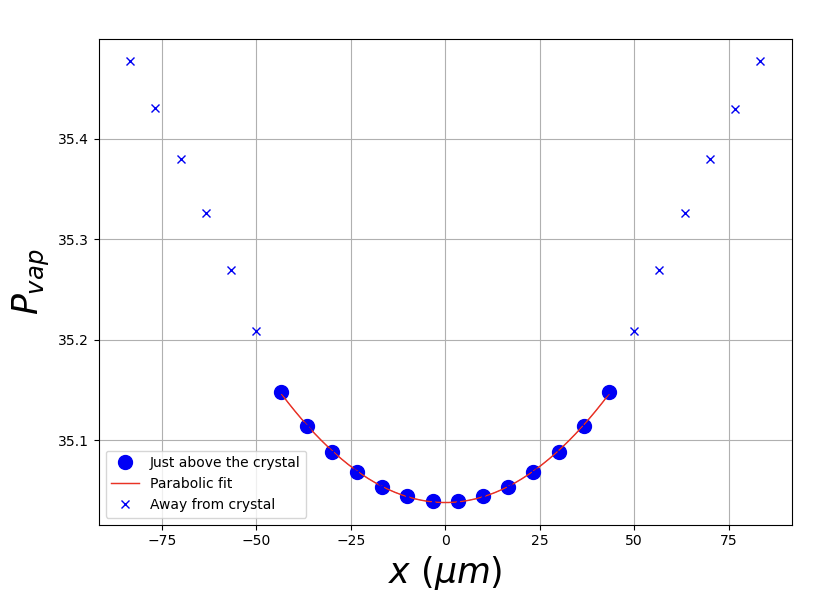

We can also define the surface supersaturation,

$$
\sigma_I(x) = {P_{surf}(x) \over P_{vap,eq}}-1 \ \ \ \ (7)
$$

The parabolic approximation (Eq. 6) expressed in terms of supersaturations is

$$
\sigma_I(x) \approx \sigma_{I,middle} -(\sigma_{I,corner}+1) \times c_r \times ({x \over L})^2  \ \ \ \ (8)
$$

where

$$
\sigma_{I,corner} = {P_{L,corner} \over  P_{vap,eq}}-1 \ \ \ \ (9)
$$

and 

$$
\sigma_{I,middle} = {P_{L,middle} \over  P_{vap,eq}}-1 \ \ \ \ (10)
$$

### Implementing Strategy B
The code below implements Strategy B, including the iterative algorithm for $g_{ice}$, in a test case scenario.

In [1]:
import numpy as np
import matplotlib.pylab as plt
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
from importlib import reload

# QLC-specific code
import QLCstuff as QLC; reload(QLC)

<module 'QLCstuff' from '/Users/nesh/Documents/Repositories/icecontinuum/nesh/Integrated_QLC_VF/QLCstuff.py'>

In [2]:
%matplotlib notebook
ticklabelsize = 15
linewidth = 1
fontsize = 15
color = 'k'
markersize = 10

# Preferred units
distance_unit = 'micrometer'
pressure_unit = 'pascal'
time_unit = 'microsecond'
temperature_unit = 'kelvin'

### Parameterization
Looks like a good set of base parameters would be: 

    Temperature = AssignQuantity(250,'kelvin')
    Pressure = AssignQuantity(30,'pascal') 
    L = AssignQuantity(30,'micrometer') 
    sigmaI_far_field = 0.3  
    
which gives $\lambda = 1.02$. 

The temperature dependence *is monotonic*:

    If we *raise* the temperature from 250 to 255 K, we get lambda = 0.90
    If we *lower* the temperature from 250 to 245 K, we get lambda = 1.16

The pressure dependence *is monotonic*:

    If we *raise* the pressure from 30 to 40 pascal, we get lambda = 0.89
    If we *lower* the pressure from 30 to 20 pascal, we get lambda = 1.25

The size dependence *is monotonic*:

    If we *raise* L from 30 to 40 micrometer, we get lambda = 0.89
    If we *lower* L from 30 to 20 micrometer, we get lambda = 1.25

The far-field supersaturation dependence *is monotonic* ...

    If we *raise* sigmaI_far_field from .30 to 0.35, we get lambda = 0.96
    If we *lower* sigmaI_far_field from .30 to 0.25, we get lambda = 1.75

At the extreme *high-lambda* (low-value) side for all four parameters, we get $\lambda = 2.37$. We can get to yet bigger $\lambda$ as we lower these parameters more. 

On the *low-lambda* side (high-value) side, the combination of low values for *any two* parameters leads to unstable results. Just not much wiggle room there.

In [3]:
parameterlist = [
[250, 30, 30, 0.3],
[245, 30, 30, 0.3]
]
iparameter = 0

In [4]:
Temperature = parameterlist[iparameter][0]
Pressure = parameterlist[iparameter][1]
L = parameterlist[iparameter][2]
sigmaI_far_field = parameterlist[iparameter][3]
    
# Temperature
Temperature = AssignQuantity(Temperature,'kelvin') 
print('Temperature =',Temperature)

# Ambient pressure
Pressure = AssignQuantity(Pressure,'pascal') 
print('Pressure =', Pressure)

# Size of the box
L = AssignQuantity(L,'micrometer') 
print('L =', L)

# The far-field supersaturation
sigmaI_far_field = AssignQuantity(sigmaI_far_field)
print('sigmaI, far field =',sigmaI_far_field)

Temperature = 250 kelvin
Pressure = 30 pascal
L = 30 micrometer
sigmaI, far field = 0.3 dimensionless


In [5]:
# The far-field distance
x_f = AssignQuantity(2000,'micrometer')
r_f = x_f

# Diffusion through air
Dvap = QLC.getDofTP(Temperature,Pressure,AssignQuantity)
print('Dvap =',Dvap)

# Difference in equilibrium supersaturation between microsurfaces I and II
sigma0 = 0.2
print('sigma0 =',sigma0)

# Equilibrium vapor stuff
R = AssignQuantity(8.314,'J/mol/kelvin')
P3 = AssignQuantity(611,'Pa')
T3 = AssignQuantity(273,'kelvin')
Delta_H_sub = AssignQuantity(50,'kJ/mol')
P_vapor_eq = P3*np.exp(-Delta_H_sub/R*(1/Temperature-1/T3))
print('P_vapor_eq =', P_vapor_eq)

# The far-field vapor pressure
P_f = P_vapor_eq * (sigmaI_far_field+1)
print('P_f =', P_f)

# Kinetic velocity
nu_kin = QLC.get_nu_kin(Temperature,AssignQuantity)
print('nu_kin = ',nu_kin)
nmpermonolayer = AssignQuantity(0.3,'nanometer')
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)
nu_kin_mlyperus = nu_kin/nmpermonolayer
nu_kin_mlyperus.ito('1/microsecond')
print('nu_kin_mlyperus =', nu_kin_mlyperus)

# Surface diffusion coefficient
D = QLC.get_D_of_T(Temperature,AssignQuantity)
print('D = ',D)

# Properties of the QLL
Nbar = 1.0
Nstar = .9/(2*np.pi)

# The equilibration time
tau_eq = AssignQuantity(1,'microsecond')

Dvap = 62773.26202925995 micrometer ** 2 / microsecond
sigma0 = 0.2
P_vapor_eq = 80.5128693847561 pascal
P_f = 104.66673020018294 pascal
nu_kin =  105.02534073012481 micrometer / second
nu_kin_mlyperus = 0.350084469100416 / microsecond
D =  0.00036467519437542267 micrometer ** 2 / microsecond


### Other starting parameters

In [6]:
# Number of points on the ice surface
Lx_reference = AssignQuantity(75,'micrometer')
nx_crystal = int(1501*L/Lx_reference)
print('nx (crystal) =', nx_crystal)
x_QLC = np.linspace(-L,L,nx_crystal)
deltax = x_QLC[1]-x_QLC[0]
print('Spacing of points on the ice surface =', deltax)
Doverdeltax2 = D/deltax**2

# Calculating the radius of the equivalent circle (the notation L_equiv is used in the documentation cell above)
perimeter_of_crystal = 8*L
L_equiv = L_eff = perimeter_of_crystal/(2*np.pi)
print('L_eff =',L_eff)

L_middle = L
print('L_middle =',L_middle)
L_corner = L*2**.5
print('L_corner =',L_corner)

nx (crystal) = 600
Spacing of points on the ice surface = 0.10016694490818168 micrometer
L_eff = 38.197186342054884 micrometer
L_middle = 30 micrometer
L_corner = 42.42640687119285 micrometer


### Now the 0d self-consistency loop

In [7]:
rho_ice = AssignQuantity(0.9,'g/cm^3')
Mvap = AssignQuantity(18,'g/mol')
g_ice = AssignQuantity(2,'micrometer/second')
g_ice_QLC = g_ice
Ntot_init_0D = 0
NQLL_init_0D = QLC.getNQLL(Ntot_init_0D,Nstar,Nbar)

# Time steps
ntimes = 200
tlast = AssignQuantity(1000,'microsecond')
tkeep_0Darr = np.linspace(0,tlast.magnitude,ntimes)
tkeep_0Darr = AssignQuantity(tkeep_0Darr,'microsecond')

for i in range(8):
    
    # Use our analytical result to predict the vapor at the surface of the crystal
    g_ice = (g_ice+g_ice_QLC)/2
    print('g_ice = ',g_ice)
    g_vap = rho_ice*g_ice*R*Temperature/Mvap; #print(gprime)
    g_vap.ito('pascal * micrometer / second'); #print(gprime)
    gprime = g_vap # Renaming this because it's called gprime in the code below
    chi = Dvap*P_f*r_f/(gprime*L_eff**2); chi.ito('dimensionless'); print('chi =', chi)
    r_0 = r_f/(1+chi); # print('r0 =', r_0)
    P1 = P_f/(1-r_0/r_f)
    P_L_eff = P1*(1-r_0/L_eff)
    P_L_middle = P1*(1-r_0/L_middle)
    P_L_corner = P1*(1-r_0/L_corner)
    c_r = (P_L_corner-P_L_middle)/P_L_corner
    c_r_percent = c_r*100
    Pvap_QLC = P_L_middle +(P_L_corner-P_L_middle)*x_QLC**2/L**2
    sigmaI_QLC = (Pvap_QLC-P_vapor_eq)/P_vapor_eq
    sigmaI_corner = sigmaI_QLC[0]
    
    # Solve the 0d QLC trajectory with the revised sigmaI
    Ntotkeep_0D, NQLLkeep_0D = QLC.run_f0d(\
            NQLL_init_0D, Ntot_init_0D, tkeep_0Darr,\
            Nbar, Nstar, sigma0, nu_kin_mlyperus, tau_eq, sigmaI_corner)
    Nicekeep_0D = Ntotkeep_0D - NQLLkeep_0D

    # Report
    g_ice_QLC = QLC.report_0d_growth_results(\
                tkeep_0Darr,NQLLkeep_0D,Ntotkeep_0D,Nicekeep_0D,Nbar,Nstar,nmpermonolayer,graphics=False)
    print('growth rates ... ')
    print('   from previous vaporfield = ',g_ice)
    print('   from QLC = ',g_ice_QLC)
    print('   difference = ',g_ice-g_ice_QLC)

print('Done with the 0d self-consistency loop')
print('c_r = ', c_r_percent, '%')

g_ice =  2.0 micrometer / second
chi = 43331.1858465396 dimensionless
growth rates ... 
   from previous vaporfield =  2.0 micrometer / second
   from QLC =  14.64178388610167 micrometer / second
   difference =  -12.64178388610167 micrometer / second
g_ice =  8.320891943050835 micrometer / second
chi = 10415.033903361162 dimensionless
growth rates ... 
   from previous vaporfield =  8.320891943050835 micrometer / second
   from QLC =  14.231649229916075 micrometer / second
   difference =  -5.910757286865239 micrometer / second
g_ice =  11.276270586483456 micrometer / second
chi = 7685.375322312584 dimensionless
growth rates ... 
   from previous vaporfield =  11.276270586483456 micrometer / second
   from QLC =  14.021075482178018 micrometer / second
   difference =  -2.7448048956945623 micrometer / second
g_ice =  12.648673034330738 micrometer / second
chi = 6851.499082778262 dimensionless
growth rates ... 
   from previous vaporfield =  12.648673034330738 micrometer / second
   fro

### Now the 1D self-consistency

Estimating times for the trajectory run
   time (est) =  315.500608330398 millisecond
   time (used) =  315.500608330398 millisecond
   dt = 1593.437415810091 microsecond
g_ice =  13.788010194408152 micrometer / second
chi = 6285.342879150602 dimensionless
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done


<IPython.core.display.Javascript object>


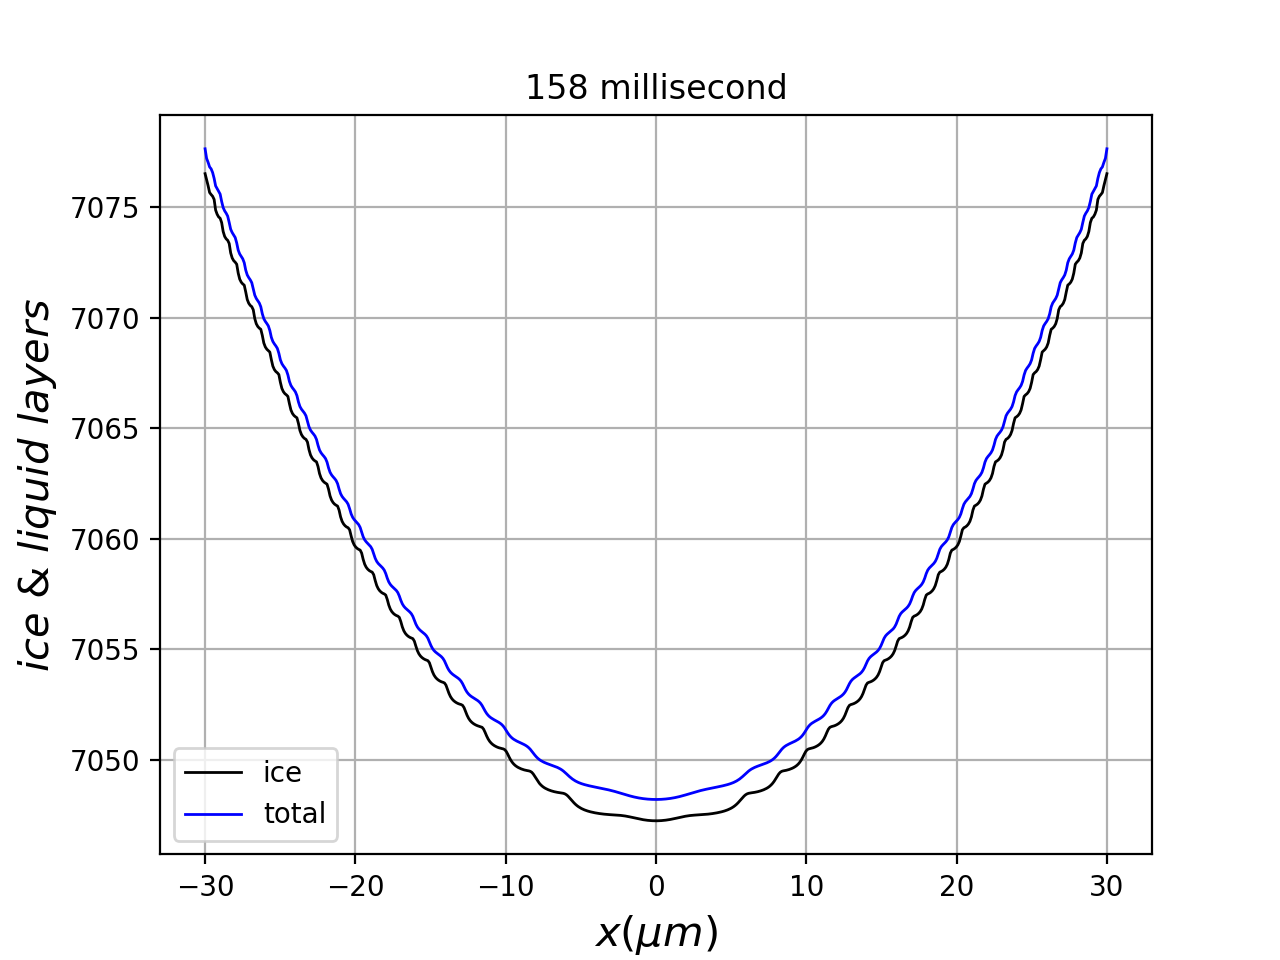

<IPython.core.display.Javascript object>


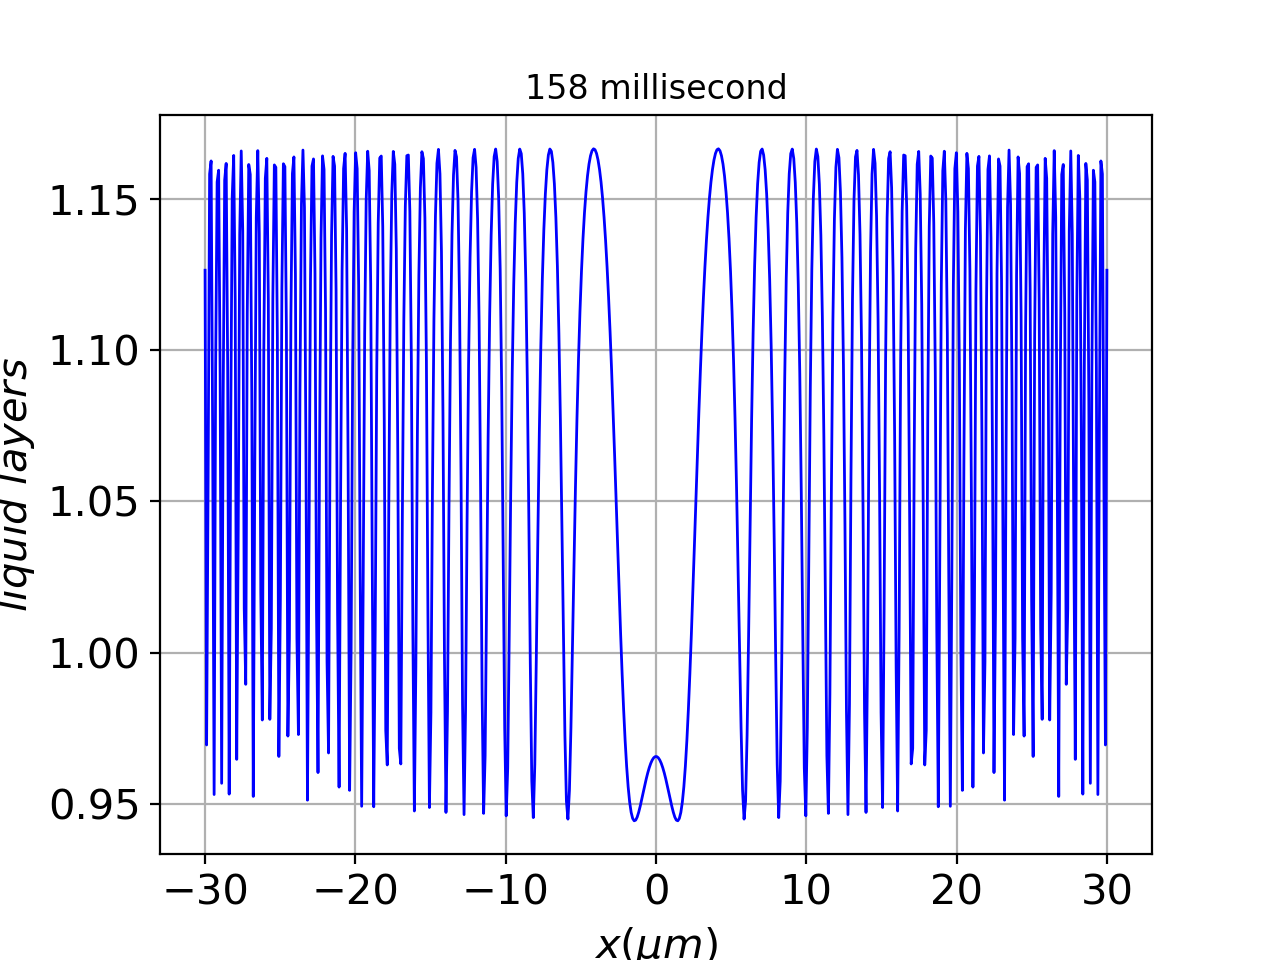

<IPython.core.display.Javascript object>


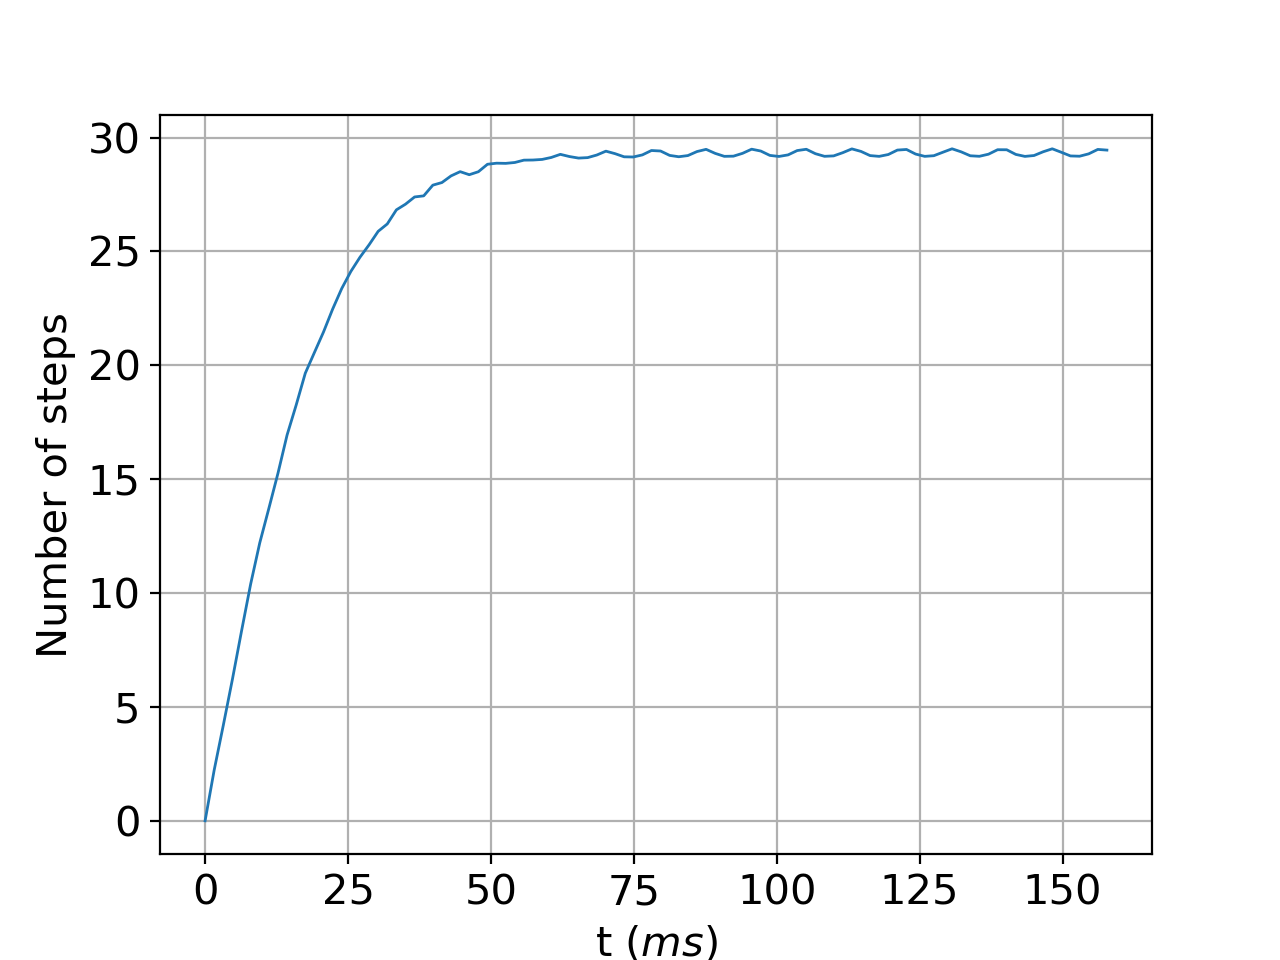

growth rates ... 
   from previous vaporfield =  13.788010194408152 micrometer / second
   from QLC =  13.402700807733003 micrometer / second
   c_r(%) = 0.3129601069335622 dimensionless


In [8]:
# Estimating/deciding on how long to make the integration
print('Estimating times for the trajectory run')
L_reference = AssignQuantity(1,'millimeter')
time_reference = AssignQuantity(1,'millisecond')
tlast_estimated = (L*L_reference/D*time_reference)**.5*1.1
tlast_estimated.ito('millisecond'); print('   time (est) = ', tlast_estimated)
tlast_msec = tlast_estimated; print('   time (used) = ',tlast_msec)
tlast = tlast_msec.to('microsecond')
tlast /= 2

# Number of time steps to report back
ntimes = 100
tkeep_1Darr = np.linspace(0,tlast,ntimes)
print('   dt =', tkeep_1Darr[1]-tkeep_1Darr[0])

# Initialize as a pre-equilibrated layer of liquid over ice
Ntot_init_1D = np.ones(nx_crystal)
NQLL_init_1D = QLC.getNQLL(Ntot_init_1D,Nstar,Nbar)

# Reporting flag
verbose = 1

for i in range(1):
    
    # Use our analytical result to predict the vapor at the surface of the crystal
    g_ice = (g_ice+g_ice_QLC)/2
    print('g_ice = ',g_ice)
    g_vap = rho_ice*g_ice*R*Temperature/Mvap; #print(gprime)
    g_vap.ito('pascal * micrometer / second'); #print(gprime)
    gprime = g_vap # Renaming this because it's called gprime in the code below
    chi = Dvap*P_f*r_f/(gprime*L_eff**2); chi.ito('dimensionless'); print('chi =', chi)
    r_0 = r_f/(1+chi); # print('r0 =', r_0)
    P1 = P_f/(1-r_0/r_f)
    P_L_middle = P1*(1-r_0/L)
    P_L_corner = P1*(1-r_0/L/2**.5)
    c_r = (P_L_corner-P_L_middle)/P_L_corner
    c_r_percent = c_r*100
    Pvap_QLC = P_L_middle +(P_L_corner-P_L_middle)*x_QLC**2/L**2
    sigmaI_QLC = (Pvap_QLC-P_vapor_eq)/P_vapor_eq
    sigmaI_corner = sigmaI_QLC[0]
    
    # 
    Ntotkeep_1D, NQLLkeep_1D = QLC.run_f1d(\
                    NQLL_init_1D, Ntot_init_1D, tkeep_1Darr,\
                    Nbar, Nstar, sigma0, nu_kin_mlyperus, Doverdeltax2, tau_eq, sigmaI_QLC,
                    AssignQuantity,\
                    verbose=0, odemethod='LSODA')
    Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D

    # Report
    g_ice_QLC = QLC.report_1d_growth_results(x_QLC,tkeep_1Darr,NQLLkeep_1D,Ntotkeep_1D,Nicekeep_1D,nmpermonolayer)
    print('growth rates ... ')
    print('   from previous vaporfield = ',g_ice)
    print('   from QLC = ',g_ice_QLC)
    print('   c_r(%) =', c_r_percent)

<IPython.core.display.Javascript object>


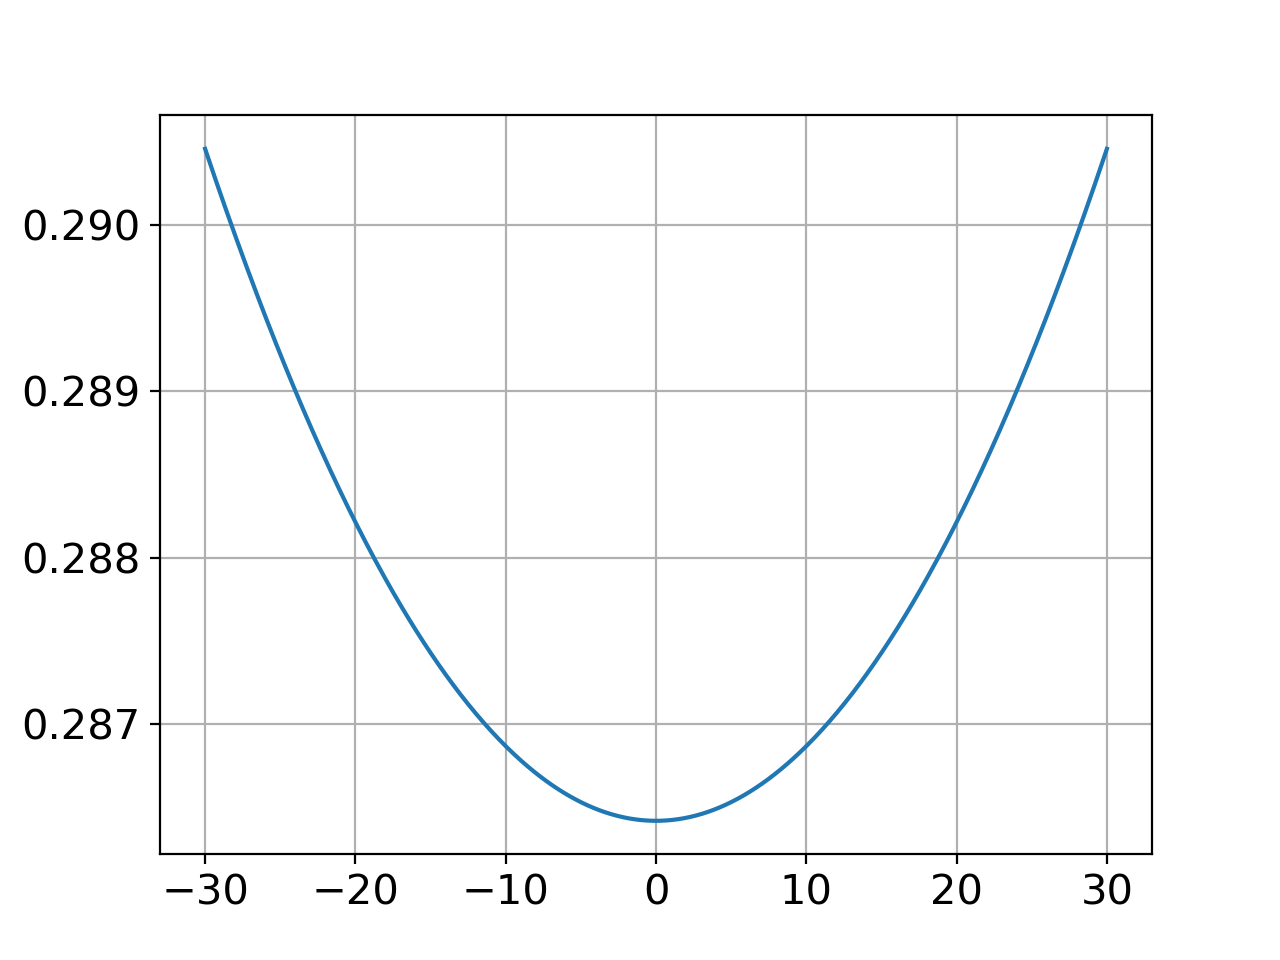

alpha far-field (%) = 42.53799040167791 dimensionless
alpha surface (%) = 43.93561879869717 dimensionless
nsteps average of last 30.0 % ( 30 points) = 29.319587124819353
estimated lambda = 1.0232067686452744 micrometer


In [9]:
plt.figure()
plt.plot(x_QLC.magnitude,sigmaI_QLC.magnitude)
plt.grid(True)
    
alpha = g_ice_QLC/(sigmaI_far_field*nu_kin)

print('alpha far-field (%) =',alpha*100)
alpha = g_ice_QLC/(sigmaI_corner*nu_kin)
print('alpha surface (%) =',alpha*100)

lastfraction = 0.3
itimes_almost_end = int(ntimes*(1-lastfraction))
f = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
nsteps_ss = np.mean(f[itimes_almost_end:-1])
print('nsteps average of last', lastfraction*100, '% (', ntimes-itimes_almost_end, 'points) =', nsteps_ss)
lambda_average = L/nsteps_ss
print('estimated lambda =', lambda_average)

In [10]:
# // %%javascript
# // var icell;
# // for(icell=1; icell<6; icell++) {
# //         Jupyter.notebook.execute_cells([icell-1]);
# // }